# <font color="blue">Submitted by: Kaspar Kadalipp</font>
# Algorithmics 2022 fall - Exam home assignment
##### <font color="#F433FF">I completed this exam on my own and cited/reported all materials that I consulted and used in my solutions</font>

### <font color='orange'> Less important code is placed here</font>
### <font color='orange'> Report is below </font>

In [1]:
import time
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen
from enum import Enum
from math import sin, cos, sqrt
import random
from tabulate import tabulate
from scipy.optimize import differential_evolution
import sigfig
from collections import defaultdict

In [2]:
# Task 1

class Card(Enum):
    red_front = 1
    red_rear = -1
    green_front = 2
    green_rear = -2
    blue_front = 3
    blue_rear = -3
    yellow_front = 4
    yellow_rear = -4


def visualize_initial_board(board):
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle('\n Given puzzle pieces', fontsize=24)
    for i, ax in enumerate(axs.flat):
        url = board[i]['url']
        img = Image.open(urlopen(url))
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


def visualize_board(board, comparisons, time):
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle(f'Solved puzzle, comparisons: {comparisons}\n time: {time * 1000 :.4f} milliseconds', fontsize=24)
    for i, ax in enumerate(axs.flat):
        row = i // 3
        col = i % 3
        # failed to solve puzzle
        if not board or board[row][col] == 0:
            img = Image.open(urlopen('https://i.imgur.com/ZWwqyVx.png'))
        else:
            url = board[row][col]['url']
            img = Image.open(urlopen(url)).rotate(board[row][col]['rotation'] * 90)
        ax.axis('off')
        ax.imshow(img)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


def is_valid(grid, row, col, card):
    global comparisons
    # adjacent cards + correct sides to compare
    values = [(row - 1, col, 0, 2), (row + 1, col, 2, 0), (row, col - 1, 3, 1), (row, col + 1, 1, 3)]
    # check constraints
    for adjacent_row, adjacent_col, adjacent_index, card_index in values:
        if 0 <= adjacent_row <= 2 and 0 <= adjacent_col <= 2:
            adjacent = grid[adjacent_row][adjacent_col]
            # non-empty cell
            if adjacent:
                # card-card comparison
                comparisons += 1
                compared_adjacent = adjacent['values'][(adjacent_index + adjacent['rotation']) % 4]
                compared_card = card['values'][(card_index + card['rotation']) % 4]
                # front has positive value, rear negative value
                if compared_adjacent.value + compared_card.value:
                    return False
    return True


def solve_puzzle(cards, grid, position=0):
    # base case: if all cells are filled, the puzzle is solved
    if position == 9:
        return grid
    # get the row and column of the current cell
    row = position // 3
    col = position % 3

    # randomization for different solutions
    # if cards:
    #     random.shuffle(cards)

    # try each card in the current cell
    for card in cards:
        if card['selected']: continue
        # try all rotations
        for rotation in range(4):
            card['rotation'] = rotation
            # check if the card is valid in the current position
            if is_valid(grid, row, col, card):
                # mark card as selected
                card['selected'] = True
                # place the card in the current cell
                grid[row][col] = card
                # move on to the next cell
                if solve_puzzle(cards, grid, position + 1):
                    return grid
                # if the puzzle is not solved, remove the card from the current cell and try the next one
                grid[row][col] = 0
                card['selected'] = False
    # if no card is valid in the current cell, backtrack
    return False


# values clockwise starting from the bottom
initial_board = [
    {'values': [Card.red_rear, Card.blue_front, Card.green_front, Card.yellow_rear],
     'rotation': 0, 'url': 'https://i.imgur.com/FjZi8rF.png', 'selected': False},
    {'values': [Card.blue_rear, Card.yellow_rear, Card.red_front, Card.green_rear],
     'rotation': 0, 'url': 'https://i.imgur.com/TDYV1xy.png', 'selected': False},
    {'values': [Card.green_rear, Card.blue_rear, Card.red_front, Card.blue_front],
     'rotation': 0, 'url': 'https://i.imgur.com/LCZdq09.png', 'selected': False},
    {'values': [Card.blue_front, Card.yellow_rear, Card.red_front, Card.green_front],
     'rotation': 0, 'url': 'https://i.imgur.com/I1R0p6T.png', 'selected': False},
    {'values': [Card.red_rear, Card.yellow_front, Card.yellow_rear, Card.blue_rear],
     'rotation': 0, 'url': 'https://i.imgur.com/9o3edcq.png', 'selected': False},
    {'values': [Card.blue_rear, Card.green_rear, Card.red_front, Card.yellow_front],
     'rotation': 0, 'url': 'https://i.imgur.com/6RPZcPx.png', 'selected': False},
    {'values': [Card.red_rear, Card.yellow_front, Card.blue_rear, Card.green_front],
     'rotation': 0, 'url': 'https://i.imgur.com/yCtQKix.png', 'selected': False},
    {'values': [Card.yellow_front, Card.green_rear, Card.red_front, Card.green_front],
     'rotation': 0, 'url': 'https://i.imgur.com/n4BKXIQ.png', 'selected': False},
    {'values': [Card.yellow_rear, Card.blue_front, Card.red_front, Card.green_rear],
     'rotation': 0, 'url': 'https://i.imgur.com/fw98pWp.png', 'selected': False},
]

# count card-card comparisons
comparisons = 0
# initial empty grid
grid = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
# run the program
ex1_start = time.time()
solution = solve_puzzle(initial_board, grid)
ex1_end = time.time()
ex1_elapsed_time = ex1_end - ex1_start

In [3]:
# Task 2

def beale(val):
    x, y = val
    return (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2


def goldstein_price(val):
    x, y = val
    return (1 + (x + y + 1) ** 2 * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * (
            30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))


def three_hump_camel(val):
    x, y = val
    return 2 * x ** 2 - 1.05 * x ** 4 + x ** 6 / 6 + x * y + y ** 2


def eggholder(val):
    x, y = val
    return -1 * (y + 47) * sin(sqrt(abs(x / 2 + (y + 47)))) - x * sin(sqrt(abs(x - (y + 47))))


def scaffer_4(val):
    x, y = val
    return 0.5 + (cos(sin(abs(x ** 2 - y ** 2))) ** 2 - 0.5) / (1 + 0.001 * (x ** 2 + y ** 2)) ** 2


def get_bounds(b: float) -> tuple:
    return (-b, b), (-b, b)


def genetic_algorithm(objective_function, bounds, goal, popsize=1000, maxiter=100, tol=1e-8):
    def fit_bounds(val):
        return max(bounds[0][0], min(val, bounds[1][1]))

    def initial_value():
        return tuple(random.uniform(lower, upper) for lower, upper in bounds)

    # for each member create 1 offspring
    def mutate(values):
        x_1, x_2, x_3 = random.sample(values, 3)
        return fit_bounds(x_1 + 0.7 * (x_2 - x_3))

    # randomly initialize population
    solutions = [initial_value() for _ in range(popsize)]
    iterations = 0
    for i in range(maxiter):
        # convergence criterion
        #if np.std(solutions) <= tol + tol * abs(np.mean(solutions)): break
        if goal * 0.9999999999 <= objective_function(solutions[0]) <= goal * 1.00000000001: break
        iterations += 1
        candidates = [{'cost': objective_function(val), 'values': val} for val in solutions]
        candidates.sort(key=lambda x: x['cost'])
        #print(f'Iteration {i}, best solution: {candidates[0]}')
        best_x = [s['values'][0] for s in candidates[:100]]
        best_y = [s['values'][1] for s in candidates[:100]]

        solutions = [candidates[0]['values']]
        for j, candidate in enumerate(candidates[1:]):
            # mutate best results with less probability
            if random.choices([False, True], weights=[popsize - j, j]):
                # mutate using values from best 10%
                mutation = (mutate(best_x), mutate(best_y))
                # If new gen is better than the base solution, keep it
                if objective_function(mutation) <= candidate['cost']:
                    solutions.append(mutation)
                else:
                    solutions.append(candidate['values'])
            else:
                # replication
                solutions.append(candidate['values'])

    return {'fun': objective_function(solutions[0]), 'x': solutions[0], 'nit': iterations}


def task2():
    parameters = [
        ['Beale', 0, beale, get_bounds(4.5)],
        ['Goldstein-Price', 3, goldstein_price, get_bounds(2)],
        ['Three-hump camel', 0, three_hump_camel, get_bounds(5)],
        ['Eggholder', -959.6407, eggholder, get_bounds(512)],
        ['Schaffer N.4', 0.292579, scaffer_4, get_bounds(100)]
    ]
    table_headers = ['function', 'goal',
                     'found optimum', 'found (x, y)', 'elapsed time', 'iter.',
                     'scipy optimum', 'scipy (x, y)', 'scipy time', 'iter.']
    table = []
    for name, goal, objective_function, bounds in parameters:
        results = [name, goal]
        for i in ['my implementation', 'scipy']:
            start = time.time()
            if i == 'scipy':
                function_result = differential_evolution(objective_function, bounds)
            else:
                function_result = genetic_algorithm(objective_function, bounds, goal)
            end = time.time()
            # results
            found_optimum = function_result['fun']
            iterations = function_result['nit']
            x, y = function_result['x']
            if not x.is_integer(): x = sigfig.round(x, 3)
            if not y.is_integer(): y = sigfig.round(y, 3)
            spacing = ' ' * (9 - len(str(x)))
            found_parameters = f"x={x}{spacing} y={y}"
            elapsed_time = f'{(end - start) * 1000:.3f} ms'
            results += [str(found_optimum), str(found_parameters), str(elapsed_time), str(iterations)]
        table.append(results)

    print(tabulate(table, tablefmt='pipe', headers=table_headers))

In [4]:
# Task 3 less important methods
def test_rotation():
    print('Test to validate rotations')
    print()
    unique_values = True
    for rotation in quarter_turns:
        unique_values = len(set(rotation)) == 24
    print('Rotations consist of unique numbers:', unique_values)

    correct_rotations = True
    for rotation in quarter_turns:
        state = solved_state
        for i in range(4):
            state = tuple(state[idx] for idx in rotation)
        correct_rotations = state == solved_state
    print('Same 4 rotations results in unchanged state:', correct_rotations)


def format_time(elapsed_time):
    if elapsed_time < 0.5:
        return f'{elapsed_time * 1000:.2f} ms'
    if elapsed_time > 60:
        return f'{int(elapsed_time // 60)} minute{"s" if elapsed_time > 120 else ""} {elapsed_time % 60:.2f} seconds'
    return f'{elapsed_time:.2f} seconds'


def ex3_visualize(data):
    plt.figure(figsize=(10, 5))
    plt.grid(axis='y', zorder=0)
    for i, v in enumerate(data.values()):
        plt.text(i, v + 30000, str(v), ha='center', color='black')

    plt.ticklabel_format(style='plain')
    plt.bar(data.keys(), data.values(), width=0.6, zorder=3)
    plt.xticks([i for i in range(15)])
    y_ticks = [200_000, 400_000, 600_000, 800_000, 1_000_000, 1_200_000, 1_400_000, 1_600_000]
    plt.yticks(y_ticks, [f'{label:,}' for label in y_ticks])
    plt.tight_layout()
    plt.xlabel("number of quarter turns to solution (k)", fontsize=16)
    plt.ylabel("Permutations", fontsize=16)
    plt.title("States reachable from fully solved state", fontsize=16)

    plt.show()


def test_solver():
    print('Validate Rubik\'s cube solutions:')
    print()
    for moves in [[0], [3, 3], [0, 0, 0], [0, 2, 4], [0, 3, 3, 4], [0, 3, 3, 4, 4, 4, 0]]:
        scrambled_state = solved_state
        goal = []
        for move in [quarter_turns[move] for move in moves]:
            scrambled_state = tuple(scrambled_state[i] for i in move)
            goal.append(reverse_name[move_names_forward[move]])
        result = optimal_bfs(scrambled_state)
        if result is None:
            print('no solution')
            print(result)
        else:
            print('Moves to scrambe:', goal)
            print(f'Solved in {len(result)} moves:', result)
            print()


def measure_solver_time_and_moves(iterations=100, random_moves=30):
    total_time = []
    total_moves = []
    forward_moves = [quarter_turns[i] for i in [0, 2, 4]]
    for _ in range(iterations):
        new_state = solved_state
        for i in range(random_moves):
            new_state = tuple(new_state[i] for i in random.choice(forward_moves))
        start = time.time()
        result = optimal_bfs(new_state)
        end = time.time()
        if result is None:
            print('No solution')
        total_time.append(end - start)
        total_moves.append(len(result))
    print('Randomly scrambled cube')
    print(f'Average time to solve: {sum(total_time) / iterations * 1000:.2f} ms')
    print(f'Average number of moves: {sum(total_moves) / iterations:.2f}')

In [5]:
# Task 3
quarter_turns = (
    #  bottom row (white)
    (0, 1, 2, 3, 4, 5, 18, 19, 8, 9, 6, 7, 12, 13, 10, 11, 16, 17, 14, 15, 22, 20, 23, 21),
    #  bottom row reverse (white-r)
    (0, 1, 2, 3, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 16, 17, 6, 7, 21, 23, 20, 22),
    #  right col (blue)
    (0, 18, 2, 16, 4, 5, 6, 7, 8, 1, 10, 3, 13, 15, 12, 14, 23, 17, 21, 19, 20, 9, 22, 11),
    #  right col reverse (blue-r)
    (0, 9, 2, 11, 4, 5, 6, 7, 8, 21, 10, 23, 14, 12, 15, 13, 3, 17, 1, 19, 20, 18, 22, 16),
    #  opposite side (red)
    (13, 15, 2, 3, 1, 5, 0, 7, 8, 9, 10, 11, 12, 23, 14, 22, 18, 16, 19, 17, 20, 21, 4, 6),
    #  opposite side reverse (red-r)
    (6, 4, 2, 3, 22, 5, 23, 7, 8, 9, 10, 11, 12, 0, 14, 1, 17, 19, 16, 18, 20, 21, 15, 13)
)
solved_state = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)

move_names_backward = {rotation: name for rotation, name in
                       zip(quarter_turns, ['white', 'white-r', 'blue', 'blue-r', 'red', 'red-r'])}
move_names_forward = {rotation: name for rotation, name in
                      zip(quarter_turns, ['white-r', 'white', 'blue-r', 'blue', 'red-r', 'red'])}
reverse_name = {name: reverse for name, reverse in zip(['white-r', 'white', 'blue-r', 'blue', 'red-r', 'red'],
                                                       ['white', 'white-r', 'blue', 'blue-r', 'red', 'red-r'])}


# Task 3.1
def bfs():
    # start from solved state
    queue = [solved_state]
    level_count = defaultdict(int, {0: 1})
    level = 0
    elapsed_time = 0
    print("\033[1mTurns \t States \t Elapsed time\033[0m")
    previous_states = {solved_state}
    # stops when there are no more moves
    while queue:
        print(f'k={level:2d}, {level_count[level]:>9,}\t\t {format_time(elapsed_time)}')
        level += 1
        next_level = []
        start = time.time()
        # go through all elements in current level
        while queue:
            current_state = queue.pop(0)
            for move in quarter_turns:
                new_permutation = tuple(current_state[i] for i in move)
                if new_permutation not in previous_states:
                    previous_states.add(new_permutation)
                    next_level.append(new_permutation)
                    level_count[level] += 1
        end = time.time()
        elapsed_time = end - start
        queue = next_level
    return level_count


# Task 3.2 ##########################################
def optimal_bfs(given_state):
    if given_state == solved_state: return []

    def backtrack(current_state, previous_moves):
        path = []
        while True:
            optimal_move = previous_moves[current_state]
            # stop when initial state is reached
            if optimal_move is None:
                path.reverse()
                return path
            move, current_state = optimal_move
            path.append(move_names_backward[move])

    # moves to backtrack to initial state
    forward_moves = {given_state: None}
    backward_moves = {solved_state: None}
    queue = [(given_state, forward_moves, backward_moves), (solved_state, backward_moves, forward_moves)]

    # God's number is 14, so 7 moves starting from both ends will find a solution
    for i in range(7):
        while queue:
            current_state, prev_moves, other_prev_moves = queue.pop(0)
            for move in quarter_turns:
                new_permutation = tuple(current_state[i] for i in move)
                if new_permutation not in prev_moves:
                    # closest move to reach current state
                    prev_moves[new_permutation] = (move, current_state)
                    queue.append((new_permutation, prev_moves, other_prev_moves))
                    if new_permutation in other_prev_moves:
                        forward_path = backtrack(new_permutation, forward_moves)
                        backward_path = backtrack(new_permutation, backward_moves)
                        backward_path = [reverse_name[move] for move in backward_path[::-1]]
                        return forward_path + backward_path

# Task 1 - Solve the 3x3 card <a href="https://www.portel.ee/product-category/ninecardpuzzle/"> puzzle </a> (by a program)

##### The 9 cards have to be arranged and rotated in the way that all houses match (same color, door-window pair).
##### 1) Analyze how many configurations of cards is there for 9 cards.
##### 2) write a pseudocode for solver into report
##### 3) Implement and study how fast you can solve it - measure the time as count the nr of card-card comparisons needed in total.
##### Report the program and the final assembly. Assembly can be done manually, no need to implement image manipulations. E.g. cut the image into 9, reorder and apply rotations after your code tells you the correct solution.

<font color="gray" size="-1">used resource: <a href="http://nifty.stanford.edu/2003/backtracking/Puzzle.html">http://nifty.stanford.edu/2003/backtracking/Puzzle.html/</a></font>


#### 1)
There are a total of 9! = 362 880 possible arrangements of the 9 cards.

For each arrangement, there are 4 possible rotations for each card, so there are $4^9$ = 262 144 possible configurations.

Therefore, the total number of configurations for the Nine Card Puzzle is 362 880 $\cdot$ 262 144 = 95,126,814,720.

#### 2)

Pseudocode for depth-first search algorithm:

1. Start with an empty 3x3 grid.
2. Choose a cell in the grid and assign a value (card) to it.
3. Check if the assignment is valid by checking the constraints. To do this, we need to check the following conditions:
   $\cdot$ The front and rear ends of the houses on the card properly fit together with the houses on the adjacent cards (if any).
   $\cdot$ The houses on the card have matching colors with houses on the adjacent cards (if any).
4. If the assignment is valid, move on to the next cell in the grid and repeat steps 2 and 3.
5. If there are no more cells, the puzzle is solved
6. If the assignment isn't valid, backtrack to the previous cell and rotate the card or try a different card .
7. Repeat this process until the puzzle is solved

#### 3)

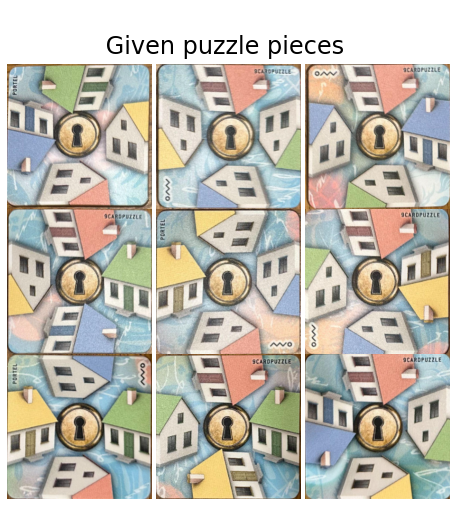

In [6]:
visualize_initial_board(initial_board)

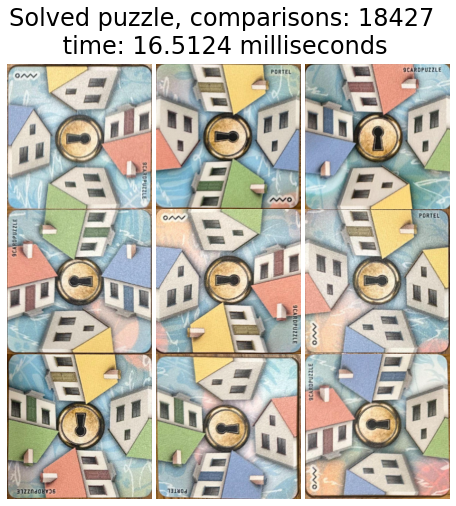

In [7]:
visualize_board(solution, comparisons, ex1_elapsed_time)

# Task 2 - Optimization

##### Write a generic differential evolution based optimisation code and optimise single-objective functions from <a href="https://en.wikipedia.org/wiki/Test_functions_for_optimization"> https://en.wikipedia.org/wiki/Test_functions_for_optimization </a> (in case of multi-dimensional inputs of $x_i$, vary i: 2, 5, 10. (Focus on these five functions: Beale, Goldstein-Price, Three-hump camel, Eggholder, and Schaffer N.4 functions). For testing try some other simple or complex functions as well, like $x^2$ , $x^4 - x^2$, sin($x$), etc ). Provide some illustrations that describe the performance of your differential evolution solver.

##### Report the found optimum; the time, and nr of steps to find that optimum. Compare your optimum to one from the wikipedia. How good is your optimiser? Discuss your findings - what is needed for a good generic solver

##### Bonus (3p): Compare your code performance to to python scipy.optimize.

<font color="gray" size="-1">used resource: <a href="https://courses.cs.ut.ee/MTAT.03.238/2022_fall/uploads/Main/09_Algorithmics_Heuristic_Search_III.pdf">https://courses.cs.ut.ee/MTAT.03.238/2022_fall/uploads/Main/09_Algorithmics_Heuristic_Search_III.pdf/</a>
</font>




In [8]:
task2()

C:\Users\kaspa\AppData\Roaming\Python\Python310\site-packages\sigfig\sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


| function         |        goal |   found optimum | found (x, y)            | elapsed time   |   iter. |   scipy optimum | scipy (x, y)            | scipy time   |   iter. |
|:-----------------|------------:|----------------:|:------------------------|:---------------|--------:|----------------:|:------------------------|:-------------|--------:|
| Beale            |    0        |     0           | x=3.0       y=0.5       | 334.763 ms     |      53 |     3.20475e-31 | x=3.0       y=0.5       | 115.283 ms   |     132 |
| Goldstein-Price  |    3        |     3           | x=-9.24e-08 y=-1.0      | 86.343 ms      |      13 |     3           | x=-1.05e-08 y=-1.0      | 24.018 ms    |      17 |
| Three-hump camel |    0        |     2.53408e-98 | x=9.68e-50  y=-1.43e-49 | 553.591 ms     |     100 |     0           | x=0.0       y=0.0       | 80.440 ms    |      95 |
| Eggholder        | -959.641    |  -959.641       | x=512.0     y=404.0     | 529.281 ms     |     100 |  -894.579       | x

My implementation is based on lecture slides.
Both my implementation and scipy implementation managed to reach a value very close to the optimum for all functions. However, Scipy didn't consistently reach the optimum for Eggholder function using default parameters.
I used a larger population but smaller number of iterations while Scipy used a small population and a large number of iterations.
Scipy certainly has a better stopping criterion than my algorithm as it achieves the optimum with smaller number of iterations. My implementation only stopped early for first two functions.
Scipy implementation is faster in every case as well. So, there is definitely room for improvement for my genetic algorithm.

What is needed for a good generic solver:
1. Efficiency: find good solutions to the optimization problem in a reasonable amount of time. This includes a reasonable early stopping criterion.
2. Robustness: handle a wide range of optimization problems, including problems with multiple local minima, constraints, and non-differentiable functions.
3. Flexibility: handle optimization problems with different types of objectives (e.g., minimization or maximization), and it should be able to handle problems with continuous, discrete, or mixed variables.
4. Ease of use: generic solver should be easy to use, with a clear and simple interface for specifying the optimization problem and setting any necessary parameters.

# Task 3 - Optimal solver for 2x2 Rubik’s cube

##### Develop the algorithms for solving the 2x2x2 Rubik´s cube (also known as pocket cube). We call the configuration of the cube ´k´ levels from the solved position if it can reach the solved configuration in exactly k twists, but not any fewer steps. Focus on 90 degree turns only

##### 1) Finding the God’s number of 2x2 Rubik cube. Analyze how many configurations there is in total. Count nr of states reachable from fully solved state in exactly k steps. Present the pseudocode. Focus on coding of each state and identifying already reached states in BFS. Implement the code and run it. If you can not reach the actual God’s number, report the initial levels up to n moves only. Report also the time required for each level k. Discuss what is needed for fast enumeration.

##### 2)  Provide a solution of an optimal solver from any state to fully assembled one. Provide  the pseudocode and analyse its complexity. Implement the solution. If you can speed it up, discuss how

##### Write in the report your findings on the 2x2 cube solver - any new and interesting observations.

<font color="gray" size="-1">used resources:

<a href="https://en.wikipedia.org/wiki/Pocket_Cube">https://en.wikipedia.org/wiki/Pocket_Cube

<a href="https://ocw.mit.edu/courses/6-006-introduction-to-algorithms-fall-2011/8a7b5b55f10715f346bf4721878b702e_MIT6_006F11_ps6_sol.pdf">https://ocw.mit.edu/courses/6-006-introduction-to-algorithms-fall-2011/8a7b5b55f10715f346bf4721878b702e_MIT6_006F11_ps6_sol.pdf<a/>

<a href="https://ocw.mit.edu/courses/6-006-introduction-to-algorithms-fall-2011/resources/ps6_code_sol/">https://ocw.mit.edu/courses/6-006-introduction-to-algorithms-fall-2011/resources/ps6_code_sol/</a>

<a href="https://medium.com/@rdonati5645/solving-a-rubiks-cube-using-graph-theory-6724e9ba68ce">https://medium.com/@rdonati5645/solving-a-rubiks-cube-using-graph-theory-6724e9ba68ce</a>
</font>

![ex3.1_0](https://i.imgur.com/FmwLg4g.png)
![ex3.1_1](https://i.imgur.com/AgxOExB.png)


1\)
Since there are 8 cubes in total then all permutations for them is $8!$.
Each cube has 3 faces, meaning it can be in 3 different orientations. If one cube is rotated incorrectly (as shown in the first illustration) the 2x2 Rubik's cube is unsolvable. Therefore, all the cubes except for one has the choice of being in 3 different orientations, this amounts to $3^7$ configurations.
Each cube can be oriented and solved in any direction in space. It has 6 sides and every side can be rotated 4 times 90 degrees as well. Therefore, $6 \cdot 4 = 24$ configurations are duplicates.

In total, there are $\frac{8! \cdot 3^7}{24} = 3,674,160$ configurations in total for 2x2 Rubik's cube.


As can be seen from the results, the deepest BFS goes is 14 quarter turns. Which means 14 is the God's number for 2x2 Rubik's cube when using only quarter turns (any configuration is reachable in 14 quarter turns).

My implementation achieves fast enumeration, because I apply rotations such that one cube never changes position. This way I never have to do additional checks for different orientations.


Pseudocode:

1. Start with a set $S_0$ containing solved cube state
2. Apply each possible move, that creates a new permutation, creating a set $S_1$ of all states that are one move from solved.
3. Apply all rotations to every state in $S_1$ to produce $S_2$, all states that are two moves from being solved. Discard any state that has previously occurred.
4. Continue for $S_3$, $S_4$, etc… until you have a set where no turn produces a new state.



In [9]:
task3_1_result = bfs()

Turns 	 States 	 Elapsed time
k= 0,         1		 0.00 ms
k= 1,         6		 0.00 ms
k= 2,        27		 0.00 ms
k= 3,       120		 0.00 ms
k= 4,       534		 1.00 ms
k= 5,     2,256		 4.53 ms
k= 6,     8,969		 21.04 ms
k= 7,    33,058		 139.19 ms
k= 8,   114,149		 1.25 seconds
k= 9,   360,508		 13.37 seconds
k=10,   930,588		 1 minute 6.86 seconds
k=11, 1,350,852		 4 minutes 51.23 seconds
k=12,   782,536		 9 minutes 43.22 seconds
k=13,    90,280		 3 minutes 37.47 seconds
k=14,       276		 9.43 seconds


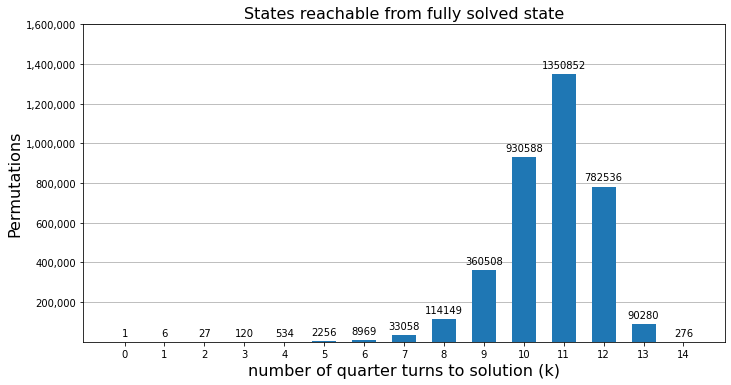

In [10]:
ex3_visualize(task3_1_result)

2\)

Optimal solver is very similar to previous BFS solution. Only difference here is generating permutations from both the solved and the scrambled states until the two meet. This allows to generate fewer states and still find the shortest path between the two states. Since God's number for quarter turns is 14 then it's only needed to considering states 7 steps ahead from both solved and scrambled states. Smaller search space is shown in the illustration below.

Pseudocode:

1. Start with a set $S_0$ containing solved cube and set $S_0'$ that contains the scrambled cube state
2. Apply each possible move, that creates a new permutation, creating a sets $S_1$ and $S_1'$ of all states that are one move from the initial state.
3. Apply all rotations to every state in $S_1$ and $S_1'$ to produce $S_2$ and $S_2'$, all states that are two moves from being solved. Discard any state that has previously occurred.
4. Continue for ($S_3$, $S_3'$), ($S_4$, $S_4'$), ($S_5$, $S_5'$), ($S_6$, $S_6'$), ($S_7$, $S_7'$) or until an element added to $S$ is present in $S'$, or the other way around.
5. Backtrack turns needed to reach initial states in both sets to get moves to solution.

In [11]:
measure_solver_time_and_moves(iterations=1000, random_moves=50)

Randomly scrambled cube
Average time to solve: 46.43 ms
Average number of moves: 10.67


In [12]:
test_solver()

Validate Rubik's cube solutions:

Moves to scrambe: ['white']
Solved in 1 moves: ['white-r']

Moves to scrambe: ['blue-r', 'blue-r']
Solved in 2 moves: ['blue-r', 'blue-r']

Moves to scrambe: ['white', 'white', 'white']
Solved in 1 moves: ['white']

Moves to scrambe: ['white', 'blue', 'red']
Solved in 3 moves: ['red-r', 'blue-r', 'white-r']

Moves to scrambe: ['white', 'blue-r', 'blue-r', 'red']
Solved in 4 moves: ['red-r', 'blue-r', 'blue-r', 'white-r']

Moves to scrambe: ['white', 'blue-r', 'blue-r', 'red', 'red', 'red', 'white']
Solved in 5 moves: ['white-r', 'red', 'blue', 'blue', 'white-r']



![ex3_2](https://i.imgur.com/1dBWKAe.png)